In [47]:
import re
import random
import pandas as pd
import hashlib

In [48]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age["age"].mean() > 80:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    # "Django", 
    # "PnP PowerShell",
    # "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [49]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ubuntu,104.455166,4.017506,10.356956,26
eDiscovery,241.290948,4.468351,12.512414,54
Network Terms,166.485968,11.099065,19.884095,15
"The Mines of the Behemoth, Shea",955.483935,19.499672,37.858921,49
Exchange Online and Defender,1042.038109,26.718926,48.710371,39
Docker,942.526007,30.404065,47.778962,31
SSH + SCP,978.369079,33.736865,54.240778,29
GUI Docker Container,941.843144,44.849674,66.220288,21
Linux,1479.491779,46.234118,67.934670,32
"Everything is Tuberculosis, Green",1121.492802,48.760557,69.462379,23


# Histogram

sum of ages: ~63208.12


<Axes: >

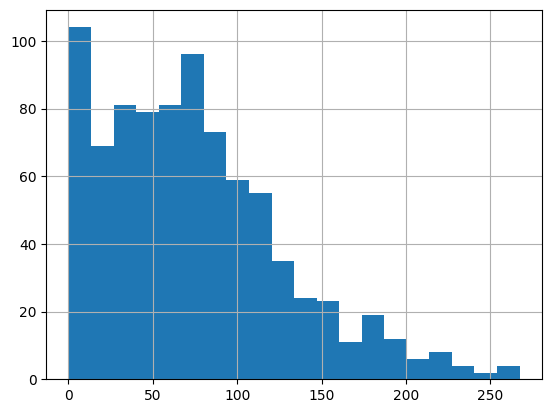

In [50]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~63208.12


<Axes: >

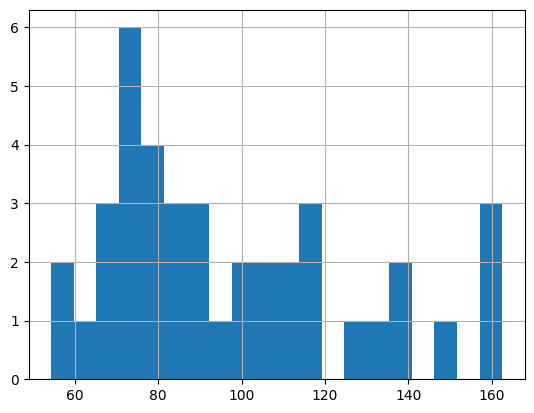

In [51]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [52]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [53]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [54]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [55]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 845
Total card age: 63208.12


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
9,Django,ALLOWED_HOSTS\nA Django setting defining which...,98abd3a22fda01e308a7bd38442e8f4c,-258.835300,-157.603419,258.8353,5516.11965,0.114712,35,0,0
12,Django,CSRF Protection\nSecurity mechanism preventing...,3aa29c837e4dd80a4bf9021d7a15f547,-220.140260,-157.603419,258.8353,5516.11965,0.114712,35,3,0
155,Django,WSGI / ASGI\nPython web server interfaces. WSG...,8176c780b3585630a0525967d5b42882,-201.627999,-157.603419,258.8353,5516.11965,0.114712,35,6,0
158,Django,MTV Pattern\nDjango’s architecture similar to ...,ab9bece6cae472ad6097facd38faaf71,-193.676582,-157.603419,258.8353,5516.11965,0.114712,35,9,0
294,Django,ORM (Object-Relational Mapper)\nLayer that let...,27fa27b252620f6d290687c6988e3b0c,-179.840112,-157.603419,258.8353,5516.11965,0.114712,35,12,0
421,Django,Scaling (Horizontal/Vertical)\nApp Service can...,b35c2b9175983f12b9f35abe7aaee2b6,-170.873053,-157.603419,258.8353,5516.11965,0.114712,35,15,0
424,Django,Template\nHTML file using Django’s template la...,424a0b24bcf10d6e3945709f3a4050ff,-142.384771,-157.603419,258.8353,5516.11965,0.114712,35,18,0
535,Django,URLconf\nMapping of URL patterns to views (url...,6c04d47d4838ecc2d8eee23f921d482a,-132.640558,-157.603419,258.8353,5516.11965,0.114712,35,21,0
627,Django,Environment Variables\nConfiguration values se...,53cc8d420d5f476b86b76cc0c6c3ae9a,-127.369397,-157.603419,258.8353,5516.11965,0.114712,35,24,0
629,Django,"Admin Site\nBuilt-in, auto-generated UI for CR...",fe810495fc19e80b475e77105ae4f775,-116.035456,-157.603419,258.8353,5516.11965,0.114712,35,27,0


## Age Max

In [56]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [57]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [58]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [59]:
existing_cards.head(10)['age'].sum()

np.float64(-1743.4234869610564)

In [60]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
4,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,-267.211087,-133.315816,267.211087,2533.000504,0.677126,19,0,0
0,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,-267.047522,-123.770528,267.047522,4331.968471,0.888622,35,0,0
5,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,-260.144408,-133.315816,267.211087,2533.000504,0.677126,19,1,1
9,Django,ALLOWED_HOSTS\nA Django setting defining which...,98abd3a22fda01e308a7bd38442e8f4c,-258.835300,-157.603419,258.835300,5516.119650,0.114712,35,0,0
14,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,-250.300198,-119.704883,250.300198,2034.983017,0.114039,17,0,0
6,Python + Oauth2.0,handler.end_headers()\n\nFinalizes the HTTP re...,91ad05cd6046d3375013aa16d642650d,-246.636541,-133.315816,267.211087,2533.000504,0.677126,19,2,2
10,Django,"Static Files\nCSS, JavaScript, and images that...",76729ae376ec4144e681846ea2579ff9,-232.298443,-157.603419,258.835300,5516.119650,0.114712,35,1,1
19,Power BI,Q: What is VertiPaq and why is it relevant whe...,2a90a97bd1a8825e67d41156094bdac0,-229.816061,-122.343446,229.816061,1223.434458,0.196567,10,0,0
24,Active Directory and Azure Files,Kerberos Double-Hop\nA delegation problem wher...,e7196e7b196b58cc0b4b2b4a6a5e6949,-228.442679,-121.752185,228.442679,4017.822112,0.012436,33,0,0
29,JavaScript Concepts,"Yarn: An alternative package manager to npm, o...",70273b4e931be2d99e6061559bdf2f39,-227.822287,-131.481820,227.822287,4733.345513,0.347118,36,0,0


In [61]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 74.803'